# [Stefan Siegert](https://stefansiegert.net)

# Training a physics-informed neural network (PINN) on the 1-d advection equation

In this note I will fit a deep neural network to spatio-temporal data (one spatial and one time dimension). The neural network produces output that fits the observed data well, and also satisfies the 1d advection equation as a physical constraint. This makes it more suitable for prediction (extrapolation in time).

This note is heavily based on the excellent blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). Read that one first and then come back here!

Download this page as a jupyter notebook: [advpinn.ipynb](advpinn.ipynb)

# Boilerplate

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Advection equation

The advection equation is a first order partial differential equation in space and time

$$\frac{\partial u}{\partial t} (x,t) + \mu \frac{\partial u}{\partial x} (x,t) = 0$$

The advection equation describes a spatial function that is translated over time at a fixed velocity $\mu$. Given an initial function at time t=0, the advection equation has analytic solutions for all times. Define $u_0(x) = u(x,0)$ as the function in space at time zero, i.e. the initial state. Then the spatio-temporal function $u(x,t) = u_0(x-\mu t)$ satisfies the advection equation, which can be easily checked by taking partial derivatives with respect to x and t. The function $u_0(x)$ simply moves towards the left or right (depending on the sign of $\mu$) without changing its shape.

Below we define the functions $u_0(x)$ as a simple squared exponential (a "bump") in space, and the corresponding $u(x,t)$ that satisfies the advection equation with a fixed known value of $\mu$. 

In [3]:
mu = 0.1
def u0(x):
    return np.exp(-100*(x-0.2)**2)
def u_true(x, t):
    return u0(x - mu * t)

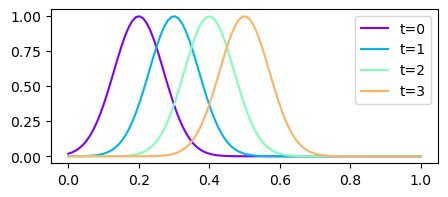

In [4]:
xx = np.linspace(0, 1, 100).reshape(-1,1)
plt.figure(figsize=(5,2))
for tt in range(4):
    plt.plot(xx, u_true(xx, tt), '-', color=cm.rainbow(tt/4), label="t="+str(tt))
plt.legend()            
plt.show()

The initial spatial profile at t=0 is advected to the right by 0.1 spatial units per time unit.

# Generate observations

We assume that we observe $u(x,t)$ at 20 equidistant points in space, and at times $t=0$ and $t=1$.

In [5]:
nx, nt = 20, 2
xt_data = np.hstack((
    np.repeat([np.linspace(0, 1, nx) ], nt, axis=0).reshape(-1,1),
    np.repeat([np.linspace(0,nt-1,nt)], nx, axis=0).T.reshape(-1,1)))
u_data = u_true(xt_data[:,0], xt_data[:,1])
xt_data = torch.tensor(xt_data).float().reshape(-1,2)
u_data = torch.tensor(u_data).float().reshape(-1,1)
print(xt_data.shape, u_data.shape)

torch.Size([40, 2]) torch.Size([40, 1])


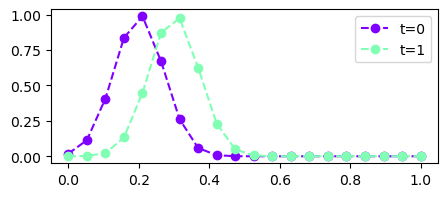

In [6]:
plt.figure(figsize=(5,2))
for tt in range(2):
    i_t = np.where( xt_data[:,1].detach().numpy() == tt )
    col = cm.rainbow(tt/2)
    plt.plot(xt_data.detach().numpy()[i_t, 0].squeeze(), 
             u_data.detach().numpy()[i_t].squeeze(),
             '--o', color=col, label="t="+str(tt))
plt.legend()
plt.show()

# Fit a deep neural network that fits the observed data

We use pytorch to train a densely connected deep neural network that takes two inputs (x and t) and generates one output (u). Here we only optimise the function so as to fit the observed data, ignoring any physical constraints.

In [7]:
torch.manual_seed(123)
model = FCN(2,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(5000):
    optimizer.zero_grad()
    uh = model(xt_data)
    loss = torch.mean((uh-u_data)**2)
    loss.backward()
    optimizer.step()

To check the behavior of the fitted model, we plot model output as a function of x for times between t=0 and t=4, and compare it to observed data and the true function.

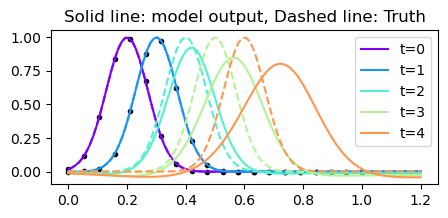

In [8]:
xt_test = torch.hstack((torch.linspace(0,1.2,100).reshape((-1,1)), 
                        torch.tensor(np.repeat([0.0],100).reshape(-1,1))))

plt.figure(figsize=(5,2))
plt.plot(xt_data[:,0].detach().numpy().squeeze(), u_data.detach().numpy().squeeze(), '.k')
for tt in range(5):
    xt_test[:,1] = tt
    col = cm.rainbow(tt/5)
    plt.plot(xt_test[:,0].numpy(), u_true(xt_test[:,0], xt_test[:,1]), '--', color=col)
    plt.plot(xt_test[:,0].numpy(), model(xt_test.float()).detach().numpy(), '-', color=col, label="t="+str(tt))
plt.legend()
plt.title("Solid line: model output, Dashed line: Truth")
plt.show()

The bell shape of the true function is captured well by the neural network output (solid line) at times t=0 and t=1. The neural network output fits the observed data (black dots) well. But when extrapolating for times t>1 the neural network output accelerates rather than keeping a constant velocity, and the function spreads out in space compared to the true solution (dashed lines). This behavior, while not completely unreasonable, is definitely not informed by the data, and must be considered an artifact of the model.

By adding the advection equation as a physical constraint we will hopefully be able to keep the shape of the function and the translation velocity relatively constant over time.

# Adding physics to the loss function

We have to make a decision about where and when we want to enforce that the physical constraint given by the advection equation. Here we limit ourselves to the spatial domain from x=0 to x=1 which corresponds to the region for which we have observation data. But we will want to use the model for prediction, i.e. extrapolation in time for times greater than t=1. 

We generate a random selection of points over that x-t domain $(0,1) \times (0,10)$ at which the physical constraint will be enforced.

In [9]:
# randomly sample points in x-t space, where x in [0,1] and t in [0,10]
np.random.seed(123)
xt_physics = np.random.uniform(size=(100,2))
xt_physics[:,1] *= 10
xt_physics = torch.tensor(xt_physics).float().requires_grad_(True)

Next we fit the neural network. The structure of the network is exactly as before (`FCN(2,1,32,3)`) but the loss function is different. Rather than requiring only that the mean squared error between model output and observed data is minimised, we also require that the model output $u(x,t)$ satisfies the advection equation closely, that is $\partial_t u(x,t) + \mu \partial_x u(x,t)$ should be close to zero at the previously sampled x/t coordinates. Since pytorch has built-in auto-differentiation, we can calculate the partial derivatives analytically using `torch.autograd.grad`, and don't need numerical approximations.

In [10]:
torch.manual_seed(123)
pinn = FCN(2,1,32,3)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(10000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh = pinn(xt_data)
    loss1 = torch.mean((uh-u_data)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp = pinn(xt_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=xt_physics, 
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudt = grad[:, 1]
    physics = dudt + mu * dudx # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean(physics**2)
    
    # backpropagate combined loss
    loss = loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()
    

Now we plot the model output and compare against the true function as before.

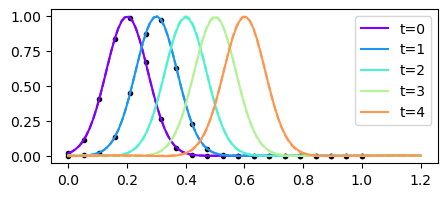

In [11]:
xt_test = torch.hstack((torch.linspace(0,1.2,100).reshape((-1,1)), 
                        torch.tensor(np.repeat([0.0],100).reshape(-1,1))))

plt.figure(figsize=(5,2))
plt.plot(xt_data.detach().numpy()[:,0], u_data.detach().numpy(), '.k')
for tt in range(5):
    xt_test[:,1] = tt
    col = cm.rainbow(tt/5)
    plt.plot(xt_test[:,0].numpy(), u_true(xt_test[:,0], xt_test[:,1]), '--', color=col)
    plt.plot(xt_test[:,0].numpy(), pinn(xt_test.float()).detach().numpy(), '-', color=col, label="t="+str(tt))
plt.legend()
plt.show()

# It worked!

Imposing the physical constraint worked. Like before, the neural network interpolates the observed data at times t=0 and t=1. But when extrapolating beyond t=1, we see that now the model output overlays the true solution almost perfectly. This is because we have trained the model to produce solutions that both fit the observed data at t=0 and t=1 well, but also satisfy the advection equation for times up to 10, which means that the spatial profile and the distance covered per unit time both remain constant in time.